In [1]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.ensemble import GradientBoostingRegressor

from category_encoders import CatBoostEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set(font_scale=1.5, palette='Set2')

В файле houses_train.csv представлен набор данных про квартиры в городе Сиэтл, штат Вашингтон. Задача — предсказать цену на жилье по имеющимся данным.

Данные имеют следующие столбцы:
* `id` — идентификационный номер жилья
* `date` — дата продажи дома
* `price` — цена
* `bedrooms` — количество спален
* `bathrooms` — количество ванных комнат, где .5 означает комнату с туалетом, но без душа
* `sqft_living` — площадь жилья
* `sqft_lot` — площадь участка
* `floors` — количество этажей
* `waterfront` — видна ли набережная
* `view` — насколько хороший вид
* `condition` — индекс от 1 от 5, отвечающий за состояние квартиры
* `grade` — 1 до 13, 1-3 соответствует плохому уровню строительства и дизайна, 3-7 — средний уровень, 11-13 — высокий.
* `sqft_above` — жилая площадь над уровнем земли
* `sqft_basement` — жилая площадь под уровнем земли
* `yr_built` — год постройки жилья
* `yr_renovated` — год последней реконструкции жилья
* `zipcode` — почтовый индекс
* `lat` — широта
* `long` — долгота
* `sqft_living15` — средняя площадь жилья ближайших 15-и соседей
* `sqft_lot15` — средняя площадь участка ближайших 15-и соседей

Исследуем зависимость качества по метрике MAPE для моделей XGBoost, LightGBM, CatBoost, а так же градиентного бустинга из sklearn, в зависимости от количества деревьев, их максимальной глубины, шага обучения, l1 и l2 регуляризаций. При исследовании одного гиперпараметра рисуйте один график для всех моделей.

Считываем данные

In [ ]:
train_df = pd.read_csv(
    'houses_train.csv', parse_dates=['date']
).drop(columns=['id'])
train_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2015-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2015-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,2016-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,2015-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


Посмотрим на их описания

In [ ]:
train_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.562600e+04,15626.000000,15626.000000,15626.000000,1.562600e+04,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000
mean,5.355339e+05,3.371240,2.111737,2073.132919,1.506655e+04,1.494304,0.007488,0.228465,3.408870,7.649878,1785.817868,287.315052,1970.937028,86.066684,98077.961858,47.559655,-122.213479,1980.853897,12689.631384
std,3.595051e+05,0.909872,0.769037,911.406092,4.235533e+04,0.539333,0.086209,0.757528,0.651925,1.171214,821.668484,439.948411,29.368239,405.398690,53.598316,0.138845,0.141089,680.403268,27103.989191
min,7.500000e+04,0.000000,0.000000,290.000000,6.000000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470225,-122.328000,1480.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.598500e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1830.000000,7620.000000
75%,6.400000e+05,4.000000,2.500000,2540.000000,1.057975e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,550.000000,1996.750000,0.000000,98118.000000,47.678200,-122.124000,2360.000000,10027.000000
max,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


In [ ]:
train_df.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

Уберем признаки `date` и `zipcode`.

In [ ]:
zipcode = train_df['zipcode']
train_df = train_df.drop(columns=['date', 'zipcode'])

Отобразим почтовый индекс на карте города, используя значения широты и долготы. Видим, что объекты разбиваются по райоам города

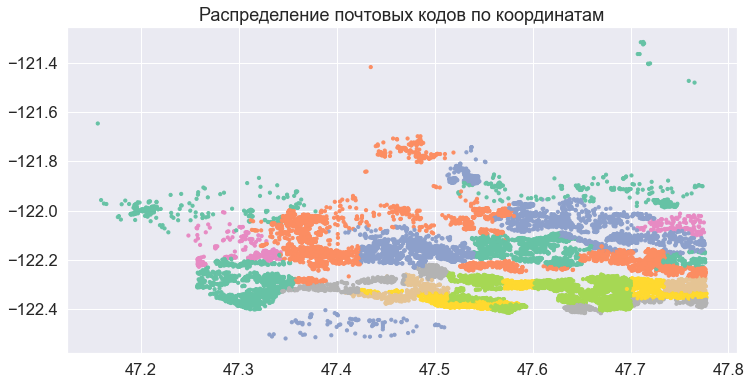

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df['lat'], train_df['long'],
            c=zipcode, cmap='Set2', s=10);
plt.title('Распределение почтовых кодов по координатам')
plt.show()

Выделим данные и таргет

In [ ]:
X_all, y_all = train_df.drop(columns=['price']), train_df['price']

Разобьем данные на обучающую и валидационную выборки. На первой будем обучать все модели, на второй &mdash; проверять качество моделей

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all, test_size=0.3, random_state=42
)

Некоторая вспомогательная функция для отрисовки графиков

In [ ]:
colors = ['#FF3300', '#0099CC', '#00CC66', 'orange']

In [ ]:
def plot_dependence_test(param_grid, mape_train, mape_valid, descr,
                         param_label, title, log_x_scale=False, ylim=(0.1, 0.2)):
    '''
    Функция для построения графиков зависимости целевой метрики
    от некоторого параметра моделей на обучающей и валидационной выборках.

    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) mape_train - значения метрик на обучающей выборке,
    3) mape_train - значения метрик на валидационной выборке,
    4) descr - описания моделей для легенды
    5) param_label - названия параметра,
    6) log_x_scale - сделать масштаб по оси x логарифмическим
    7) title - заголовок для графика.
    '''

    plt.figure(figsize=(16, 9))

    for i in range(len(mape_train)):
        plt.plot(param_grid, mape_train[i], color=colors[i],
                 linewidth=2, alpha=0.7, linestyle='--',
                 label=f'{descr[i]} train')
        plt.plot(param_grid, mape_valid[i], color=colors[i],
                 linewidth=4, alpha=0.7,
                 label=f'{descr[i]} valid')

    plt.xlabel(param_label)
    plt.ylabel('MAPE, %')
    plt.legend(ncol=2)
    plt.title(title)
    if log_x_scale:
        plt.xscale('log')
    plt.ylim(ylim)
    plt.show()

### 1. Зависимость от количества деревьев

Для каждой модели используем функции получения предсказания с ограничением количества деревьев при предсказаний. Это позволяет не обучать каждый раз одни и те же модели.

In [ ]:
n_estimators_grid = np.arange(1, 1000)

# GB sklearn
regressor = GradientBoostingRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train, y_train)
mape_train = [[mape(y_train, prediction)
               for prediction in regressor.staged_predict(X_train)]]
mape_valid = [[mape(y_valid, prediction) for
               prediction in regressor.staged_predict(X_valid)]]

# XGBoost
regressor = XGBRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train, y_train)
mape_train += [[mape(y_train, regressor.predict(X_train, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(X_valid, ntree_limit=i+1))
                for i in range(max(n_estimators_grid))]]

# LightGBM
regressor = LGBMRegressor(n_estimators=max(n_estimators_grid))
regressor.fit(X_train, y_train)
mape_train += [[mape(y_train, regressor.predict(X_train,
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(X_valid,
                                                num_iteration=i+1))
                for i in range(max(n_estimators_grid))]]

# CatBoost
regressor = CatBoostRegressor(n_estimators=max(n_estimators_grid), silent=True)
regressor.fit(X_train, y_train)
mape_train += [[mape(y_train, regressor.predict(X_train, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]
mape_valid += [[mape(y_valid, regressor.predict(X_valid, ntree_end=i+1))
                for i in range(max(n_estimators_grid))]]

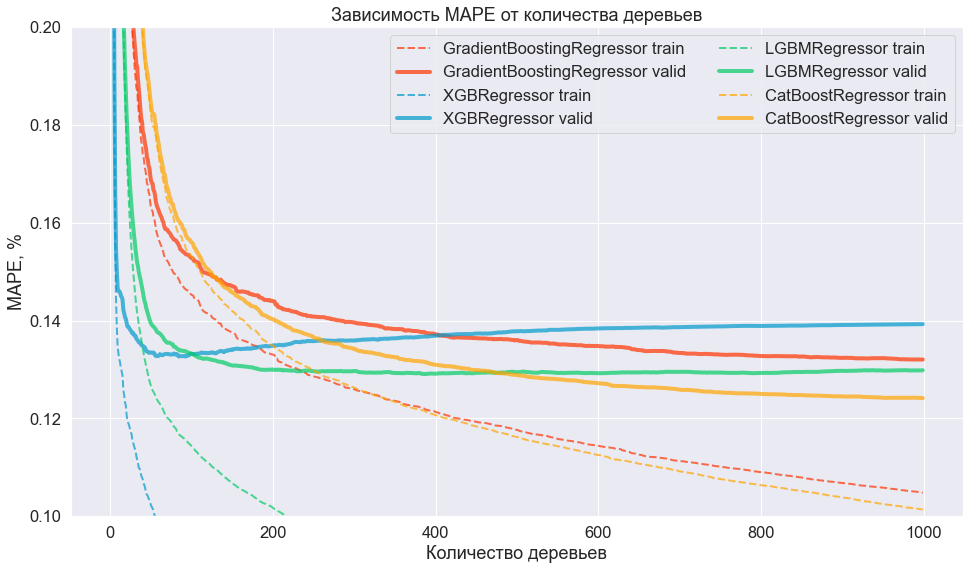

In [ ]:
plot_dependence_test(
    param_grid=n_estimators_grid,
    mape_train=mape_train,
    mape_valid=mape_valid,
    descr=['GradientBoostingRegressor', 'XGBRegressor',
           'LGBMRegressor', 'CatBoostRegressor'],
    param_label='Количество деревьев',
    title='Зависимость MAPE от количества деревьев',
)

**Вывод:** XGBoost и LightGBM позволяет быстро получить довольно приемлемое качество на небольшом количестве деревьев. Однако при увеличении количества деревьев они начинают переобучаться. Реализации из sklearn и CatBoost'у требуется большое количество деревьев для получения хорошего качества, причем при увеличении количества деревьев не наблюдается переобучения. Подобные свойства наблюдаются у реализации из sklearn. Наилучшее качество на валидационной выборке позволяет получить CatBoost.

### 2. Зависимость от максимальной глубины дерева

In [ ]:
max_depth_grid = np.arange(2, 12)

mape_train, mape_valid = np.zeros((2, 4, len(max_depth_grid)))

for i, max_depth in tqdm(enumerate(max_depth_grid), total=len(max_depth_grid)):
    # GB sklearn
    regressor = GradientBoostingRegressor(max_depth=max_depth)
    regressor.fit(X_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(X_valid))

    # XGBoost
    regressor = XGBRegressor(max_depth=max_depth)
    regressor.fit(X_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(X_valid))

    # LightGBM
    regressor = LGBMRegressor(max_depth=max_depth)
    regressor.fit(X_train, y_train)
    mape_train[2, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[2, i] = mape(y_valid, regressor.predict(X_valid))

    # CatBoost
    regressor = CatBoostRegressor(max_depth=max_depth, silent=True)
    regressor.fit(X_train, y_train)
    mape_train[3, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[3, i] = mape(y_valid, regressor.predict(X_valid))

  0%|          | 0/10 [00:00<?, ?it/s]

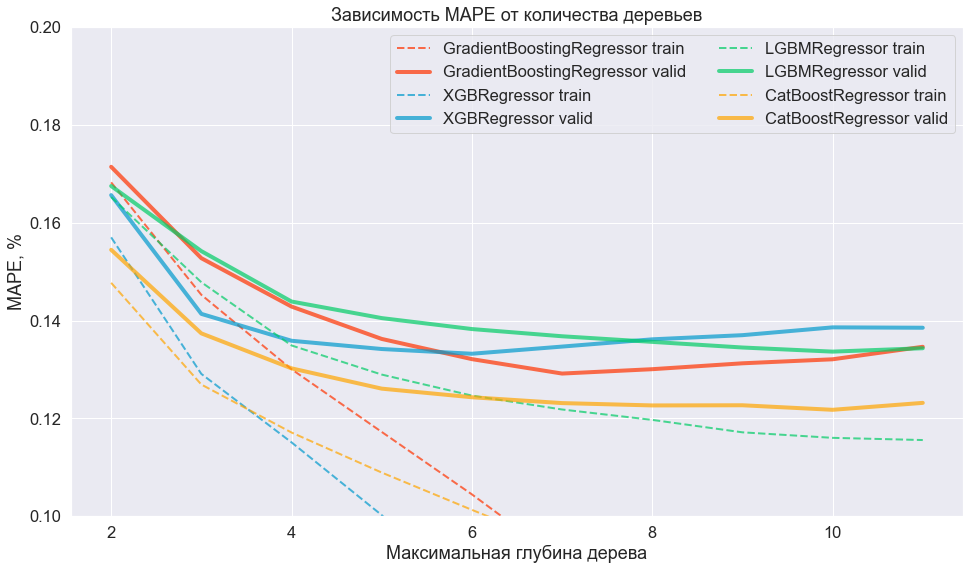

In [ ]:
plot_dependence_test(
    param_grid=max_depth_grid,
    mape_train=mape_train,
    mape_valid=mape_valid,
    descr=['GradientBoostingRegressor', 'XGBRegressor',
           'LGBMRegressor', 'CatBoostRegressor'],
    param_label='Максимальная глубина дерева',
    title='Зависимость MAPE от количества деревьев',
)

**Вывод:** Оптимальная глубина дерева для разных моделей равна от 5 до 8. Модели XGBoost и sklearn-реализация начинают переобучаться с увеличением глубины дерева. Модели LightGBM и CatBoost ведут себя более устойчиво.

### 3. Зависимость от `learning_rate`

In [ ]:
learning_rate_grid = np.logspace(np.log10(0.01), np.log10(0.6), 20)

mape_train, mape_valid = np.zeros((2, 4, len(learning_rate_grid)))

for i, learning_rate in tqdm(enumerate(learning_rate_grid),
                             total=len(learning_rate_grid)):
    regressor = GradientBoostingRegressor(learning_rate=learning_rate)
    regressor.fit(X_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = XGBRegressor(learning_rate=learning_rate)
    regressor.fit(X_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = LGBMRegressor(learning_rate=learning_rate)
    regressor.fit(X_train, y_train)
    mape_train[2, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[2, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = CatBoostRegressor(learning_rate=learning_rate, silent=True)
    regressor.fit(X_train, y_train)
    mape_train[3, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[3, i] = mape(y_valid, regressor.predict(X_valid))

  0%|          | 0/20 [00:00<?, ?it/s]

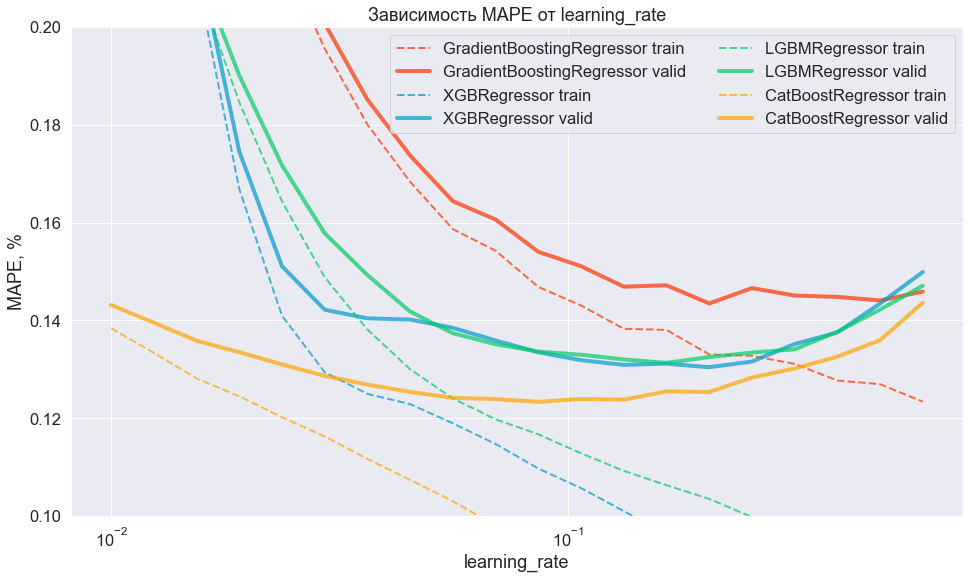

In [ ]:
plot_dependence_test(
    param_grid=learning_rate_grid,
    mape_train=mape_train,
    mape_valid=mape_valid,
    descr=['GradientBoostingRegressor', 'XGBRegressor',
           'LGBMRegressor', 'CatBoostRegressor'],
    param_label='learning_rate',
    title='Зависимость MAPE от learning_rate',
    log_x_scale=True,
)

**Вывод:** Для каждой модели наблюдается некоторое оптимальное значение `learning_rate`. При меньших значениях модели недообучаются, при больших значениях наблюдается ухудшение качество и некоторое колебание результатов. Модель CatBoost показывает наилучшее качество.

### 4. Зависимость от параметра l2-регуляризации

У XGBoost, LightGBM, CatBoost есть параметр, отвечающий за l2-регуляризацию. Посмотрим на результаты для него.

In [ ]:
l2_grid = np.logspace(-3, 3, 20)

mape_train, mape_valid = np.zeros((2, 3, len(l2_grid)))

for i, l2_coef in tqdm(enumerate(l2_grid), total=len(l2_grid)):
    regressor = XGBRegressor(reg_lambda=l2_coef)
    regressor.fit(X_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = LGBMRegressor(reg_lambda=l2_coef)
    regressor.fit(X_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = CatBoostRegressor(l2_leaf_reg=l2_coef, silent=True)
    regressor.fit(X_train, y_train)
    mape_train[2, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[2, i] = mape(y_valid, regressor.predict(X_valid))

  0%|          | 0/20 [00:00<?, ?it/s]

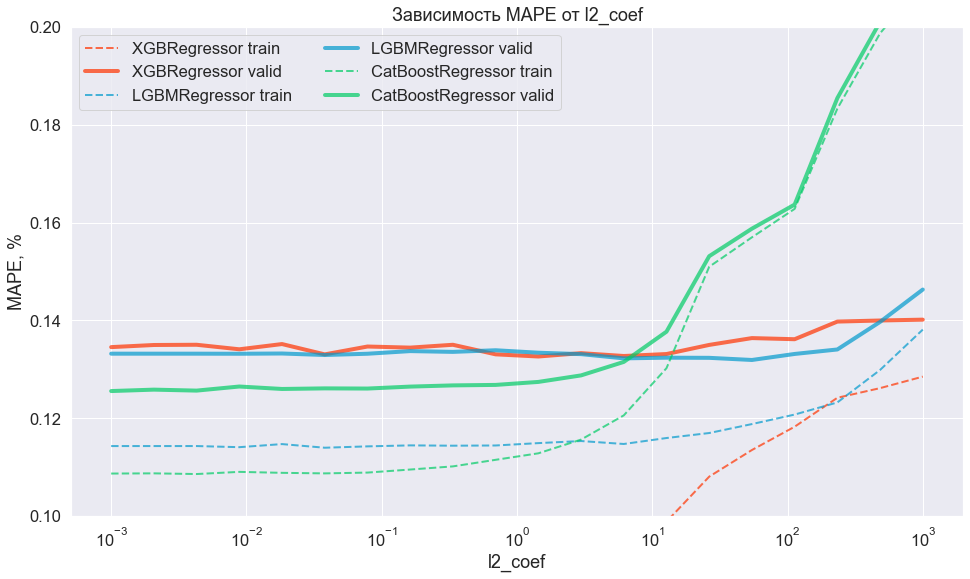

In [ ]:
plot_dependence_test(
    param_grid=l2_grid,
    mape_train=mape_train,
    mape_valid=mape_valid,
    descr=['XGBRegressor', 'LGBMRegressor', 'CatBoostRegressor'],
    param_label='l2_coef',
    title='Зависимость MAPE от l2_coef',
    log_x_scale=True,
)

**Вывод:** Для всех моделей кроме CatBoost сложно заметить влияние данного параметра.

### 5. Зависимость от параметра l1-регуляризации

У XGBoost, LightGBM есть параметр, отвечающий за l1-регуляризацию. Посмотрим на результаты для него.

In [ ]:
l1_grid = np.logspace(-3, 3, 20)

mape_train, mape_valid = np.zeros((2, 2, len(l1_grid)))

for i, l1_coef in tqdm(enumerate(l1_grid), total=len(l1_grid)):
    regressor = XGBRegressor(reg_alpha=l1_coef)
    regressor.fit(X_train, y_train)
    mape_train[0, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[0, i] = mape(y_valid, regressor.predict(X_valid))

    regressor = LGBMRegressor(reg_alpha=l1_coef)
    regressor.fit(X_train, y_train)
    mape_train[1, i] = mape(y_train, regressor.predict(X_train))
    mape_valid[1, i] = mape(y_valid, regressor.predict(X_valid))

  0%|          | 0/20 [00:00<?, ?it/s]

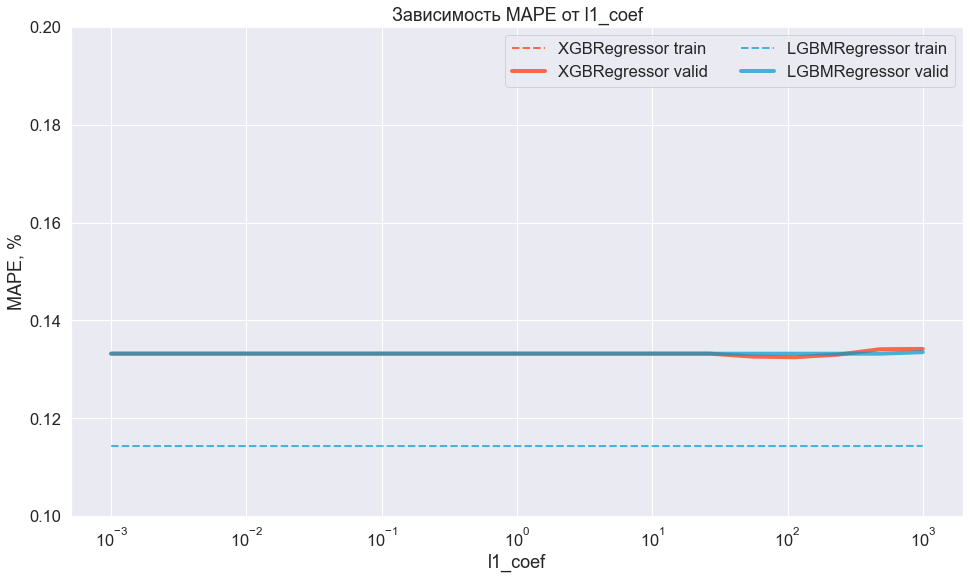

In [ ]:
plot_dependence_test(
    param_grid=l1_grid,
    mape_train=mape_train,
    mape_valid=mape_valid,
    descr=['XGBRegressor', 'LGBMRegressor'],
    param_label='l1_coef',
    title='Зависимость MAPE от l1_coef',
    log_x_scale=True,
)

**Вывод:** Влияние этого параметра так же не очень значительно.